# TensorFlow for ICT Applications

## Lab session 4: Convolutional networks

**Contents of this lab session:**

1. Loading image data with Keras.
2. Downloading a custom model and fine-tuning it.

### Downloading the dataset and setting up the virtual machine

**Important**: this section is only needed if you are running a Google Colaboratory virtual environment.

Download the "EUROSat" dataset from here: http://madm.dfki.de/downloads

In [1]:
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip

--2019-05-10 09:08:50--  http://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M  21.0MB/s    in 5.5s    

2019-05-10 09:08:56 (16.3 MB/s) - ‘EuroSAT.zip’ saved [94280567/94280567]



In [0]:
!unzip -q EuroSAT.zip 

In [ ]:
!pip install tensorflow-gpu==2.0.0-alpha0

### Loading image data in Keras

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

See here for the full documentation of the Keras image generator: https://keras.io/preprocessing/image/.

Alternatively, we could have loaded images using tf.data, but in the case of separated folders using the Keras interface is slightly easier: https://www.tensorflow.org/tutorials/load_data/images.

In [3]:
train_datagen = ImageDataGenerator(validation_split=0.2, rescale=1.0/255)

In [4]:
dataset_path = './data/eurosat/'
train_it = train_datagen.flow_from_directory(dataset_path, target_size=(64, 64), batch_size=32, subset='training')
val_it = train_datagen.flow_from_directory(dataset_path, target_size=(64, 64), batch_size=32, subset='validation')

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


Desired target for the image is:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


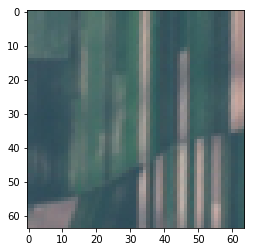

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
for xb, yb in train_it:
    plt.imshow(xb[0, :, :, :])
    print('Desired target for the image is: ', yb[0])
    break

### Downloading a pretrained model in Keras

https://www.tensorflow.org/api_docs/python/tf/keras/models/Model

In [8]:
from tensorflow.keras import applications
vgg = applications.vgg19.VGG19(include_top=False, input_shape=(64, 64, 3))

In [9]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [10]:
# Make all layers non-trainable (i.e., "freeze" the layers)
for l in vgg.layers:
    l.trainable = False

In [11]:
from tensorflow.keras import models, layers

In [12]:
# Add a single layer for classification
m = models.Sequential()

m.add(vgg)
m.add(layers.Flatten())
m.add(layers.Dense(10, activation='softmax'))

m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 20,044,874
Trainable params: 20,490
Non-trainable params: 20,024,384
_________________________________________________________________
